# Patient 1 Results

Here are results for patient SBRT_lung_minsun, with the D2cm MaxDose parameter tuned between the range [0,2400] and the Rib MaxDose parameter tuned between [0,4000]. I compare both the approved plan, the plan without any parameter tuning ('default'), the plan with random sampling ('dummy'), and the plan with Bayesian optimization ('bayes').

My objective function terms in RayStation were taken directly from the clinical goals, with the exception of a PTV MaxDose that I've added. I chose to tune only the D2cm and the Rib parameter by looking at which goals in the default plan were within 10% of the AcceptanceLevel value. I only tuned one of the Rib parameters (the MaxDvh goal in the default plan was right on the border, but I figured the MaxDose parameter would influence both of these goal values). While the PTV MaxDose was technically within 10% of it's goal value in the default plan, I didn't tune it because it wasn't part of the original clinical goals.

The plans from random sampling and Bayesian optimization ended up being fairly similar. Neither of them met the D2cm goal, but they were very close (and closer than the approved plan), but they did reduce the dose to the Rib.

I used a linear-quadratic utility score in my optimization. When a goal value was better than the AcceptanceValue, it contributed linearly to the utility score (as the percent difference), but when a goal value was worse than the AcceptanceLevel, it contributed quadratically to the utility score (as the percent difference squared). 

In [10]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import skopt
from skopt import plots
sns.set(color_codes=True, font_scale=1.2)

sys.path.append('../../src')
import raybay

In [16]:
# Load treatment plan results
approved = np.load('approved/res.pkl', allow_pickle=True)
default = np.load('default/res.pkl', allow_pickle=True)
res_dummy = np.load('pars/res_linear_quadratic_dummy_minimize.pkl', allow_pickle=True)
res_bayes = np.load('pars/res_linear_quadratic_gp_minimize.pkl', allow_pickle=True)

In [7]:
res_bayes.patient

'SBRT_lung_minsun'

In [8]:
res_bayes.goal_df

,Roi,Type,GoalCriteria,AcceptanceLevel,ParameterValue
0,Bronchus,MaxDvh,AtMost,1560,18.52
1,Bronchus,MaxDose,AtMost,3480,NaN
2,Chestwall_L,MaxDvh,AtMost,3000,2.04
3,D2cm,MaxDose,AtMost,2400,NaN
4,Esophagus,MaxDvh,AtMost,1880,16.91
5,Esophagus,MaxDose,AtMost,3000,NaN
6,GreatVes,MaxDvh,AtMost,4300,5.66
7,GreatVes,MaxDose,AtMost,4900,NaN
8,Heart,MaxDvh,AtMost,2800,1.84
9,Heart,MaxDose,AtMost,3400,NaN


In [9]:
res_bayes.func_df

,Roi,FunctionType,DoseLevel,PercentVolume,EudParameterA,Weight
0,Bronchus,MaxDvh,1560,18.52,NaN,1
1,Bronchus,MaxDose,3480,0.00,NaN,1
2,Chestwall_L,MaxDvh,3000,2.04,NaN,1
3,D2cm,MaxDose,"[0,2400]",0.00,NaN,1
4,Esophagus,MaxDvh,1880,16.91,NaN,1
5,Esophagus,MaxDose,3000,0.00,NaN,1
6,GreatVes,MaxDvh,4300,5.66,NaN,1
7,GreatVes,MaxDose,4900,0.00,NaN,1
8,Heart,MaxDvh,2800,1.84,NaN,1
9,Heart,MaxDose,3400,0.00,NaN,1


Here are the values for each of the clinical goals achieved by each plan, with the first column listing the AcceptanceLevel from the clinical goals.

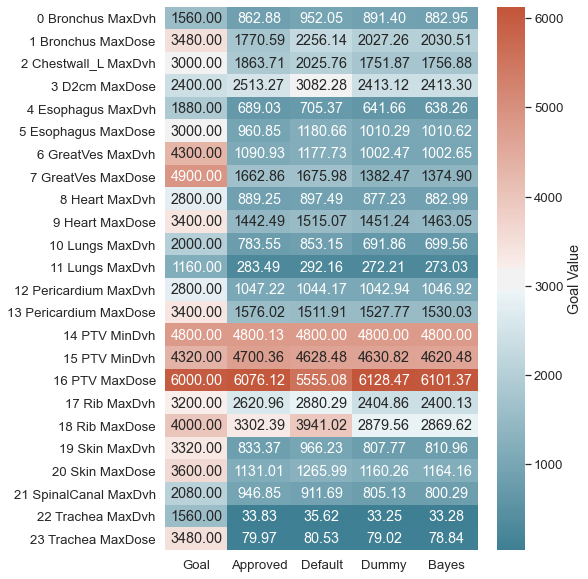

In [3]:
# Compare goal values
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
X = np.zeros((len(approved.goal_df),5))
for index, row in approved.goal_df.iterrows():
    X[index, 0] = row['AcceptanceLevel']
    X[index, 1] = approved.goal_dict[index][0]
    X[index, 2] = default.goal_dict[index][0]
    X[index, 3] = res_dummy.goal_dict[index][idx_dummy]
    X[index, 4] = res_bayes.goal_dict[index][idx_bayes]
Y = pd.DataFrame(columns=['Goal', 'Approved', 'Default', 'Dummy', 'Bayes'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(7, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Goal Value'},
            fmt=".2f");

Here are the same values, expressed as percent differences.

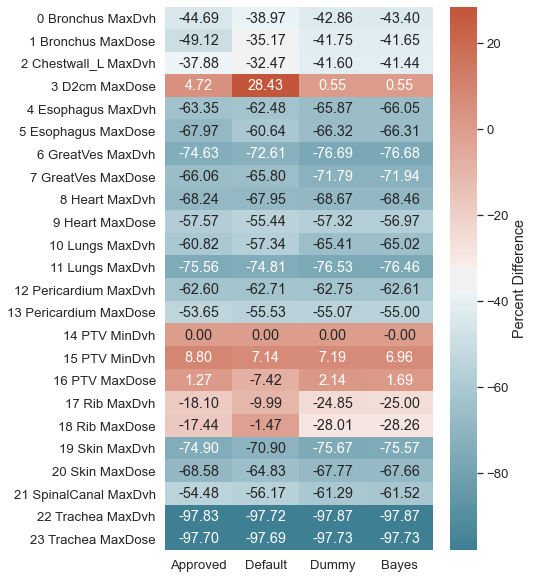

In [4]:
# Compare goal percent difference
roi_dict = {
    f"{index} {row['Roi']} {row['Type']}": index for index, row in approved.goal_df.iterrows()
}
idx_dummy = np.argmin(res_dummy.opt_result.func_vals)
idx_bayes = np.argmin(res_bayes.opt_result.func_vals)
X = np.zeros((len(approved.goal_df),4))
for index, row in approved.goal_df.iterrows():
    X[index, 0] = -raybay.get_term(approved.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 1] = -raybay.get_term(default.goal_dict[index][0], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 2] = -raybay.get_term(res_dummy.goal_dict[index][idx_dummy], row['AcceptanceLevel'], 'Max', 'linear')
    X[index, 3] = -raybay.get_term(res_bayes.goal_dict[index][idx_bayes], row['AcceptanceLevel'], 'Max', 'linear')
Y = pd.DataFrame(columns=['Approved', 'Default', 'Dummy', 'Bayes'], data=X, index=roi_dict)
f, ax = plt.subplots(1, figsize=(6, 10))
sns.heatmap(Y, annot=True, cmap=sns.diverging_palette(220, 20, n=256), ax=ax, cbar_kws={'label': 'Percent Difference'},
            fmt='.2f');

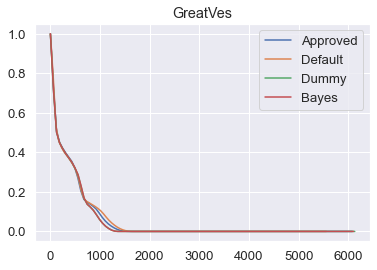

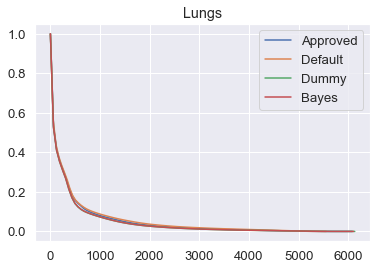

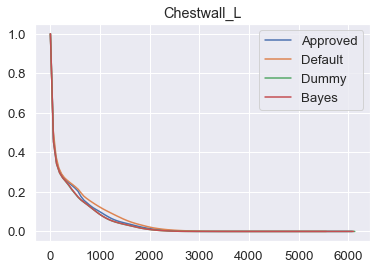

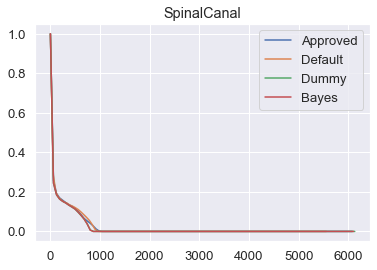

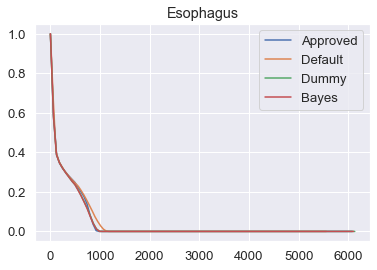

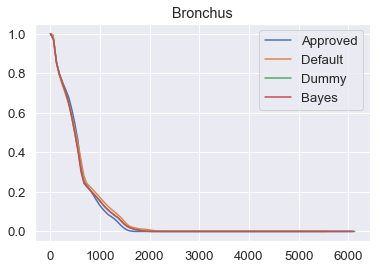

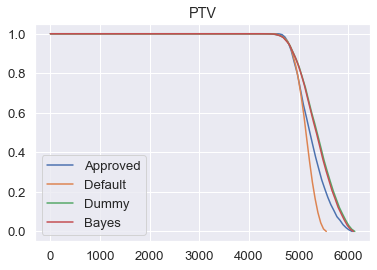

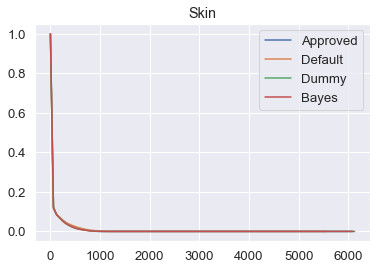

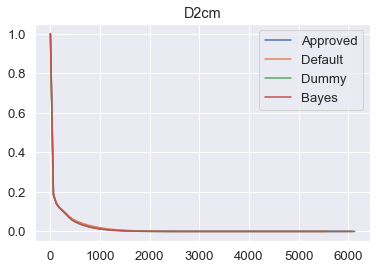

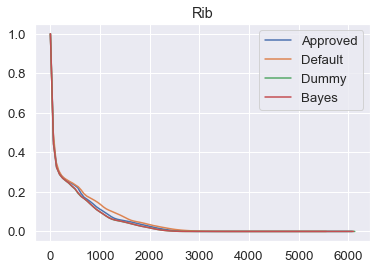

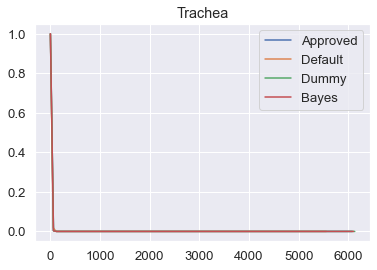

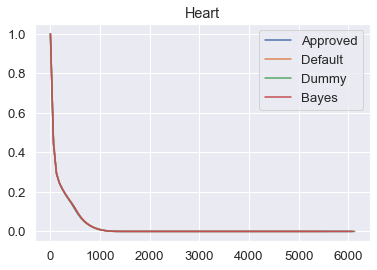

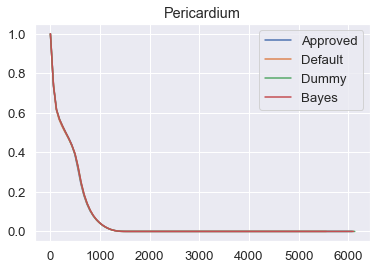

In [5]:
for roi in approved.roi_list:
    plt.figure()
    plt.plot(approved.dvh_dict['Dose'], approved.dvh_dict[roi])
    plt.plot(default.dvh_dict['Dose'], default.dvh_dict[roi])
    plt.plot(res_dummy.dvh_dict['Dose'], res_dummy.dvh_dict[roi])
    plt.plot(res_bayes.dvh_dict['Dose'], res_bayes.dvh_dict[roi])
    plt.title(roi)
    plt.legend(['Approved', 'Default', 'Dummy', 'Bayes'])

Here is an example of what the utility terms look like.

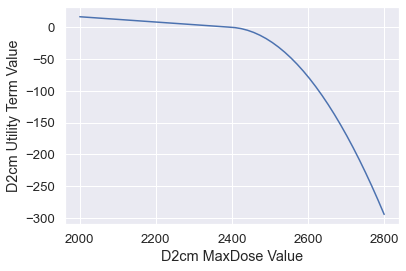

In [14]:
vals = np.linspace(2000, 2800)
util = [raybay.get_term(val, 2400, 'Max', 'linear_quadratic') for val in vals]
plt.plot(vals, util)
plt.xlabel('D2cm MaxDose Value')
plt.ylabel('D2cm Utility Term Value');

The Bayesian optimization routine found its minimum value sooner than the random sampling.

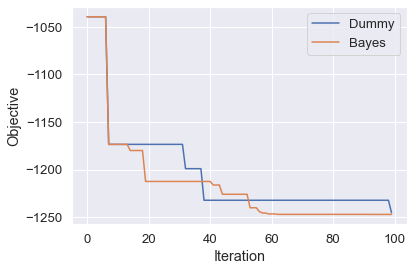

In [6]:
# Objective convergence
plt.plot(np.minimum.accumulate(res_dummy.opt_result.func_vals))
plt.plot(np.minimum.accumulate(res_bayes.opt_result.func_vals))
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.legend(['Dummy', 'Bayes']);

The Bayesian optimization routine zeroed in on a good region to sample around iteration 50.

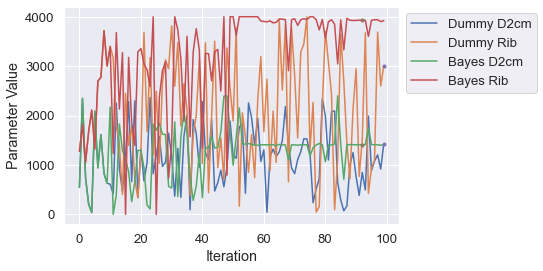

In [7]:
# Parameter convergence
plt.plot(res_dummy.opt_result.x_iters)
plt.plot(res_bayes.opt_result.x_iters)
plt.plot(idx_dummy*np.ones(2), res_dummy.opt_result.x_iters[idx_dummy], '.')
plt.plot(idx_bayes*np.ones(2), res_bayes.opt_result.x_iters[idx_bayes], '.')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.legend(['Dummy D2cm', 'Dummy Rib', 'Bayes D2cm', 'Bayes Rib'], bbox_to_anchor=(1, 1))

When we plot our samples vs. the utility (sorry, sometimes I'm looking it as trying to maximize utility, sometimes minimize... confusing), we get an interesting shape. Aside from the range [0,1000], the Rib parameter doesn't influence the utility too much, but the D2cm parameter creates an almost parabolic utility shape.

<IPython.core.display.Javascript object>


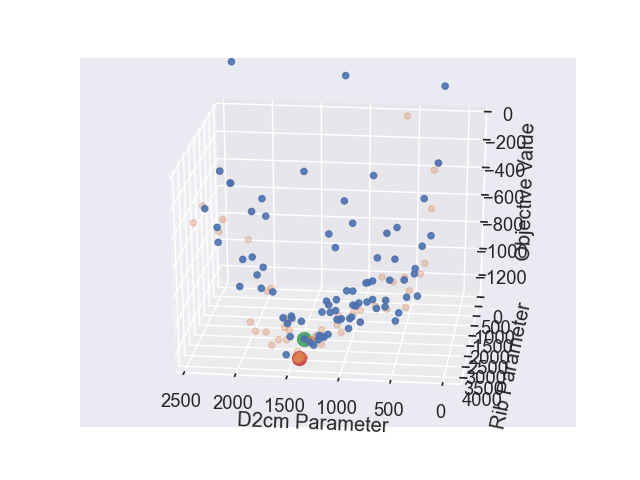

In [10]:
# Parameters vs. Objective
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
             [row[1] for row in res_dummy.opt_result.x_iters], 
             res_dummy.opt_result.func_vals)
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.opt_result.func_vals)
ax.scatter3D(res_dummy.opt_result.x_iters[idx_dummy][0],
             res_dummy.opt_result.x_iters[idx_dummy][1], res_dummy.opt_result.fun, s=100)
ax.scatter3D(res_bayes.opt_result.x_iters[idx_dummy][0],
             res_bayes.opt_result.x_iters[idx_bayes][1], res_bayes.opt_result.fun, s=100)
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Objective Value')
ax.set_zlim([-1300, 0]);

The D2cm goal value is influencing the utility more than the Rib value due to the shape of the utility function. The D2cm value is much more likely to be near the quadratic region of the utility than the Rib value.

<IPython.core.display.Javascript object>


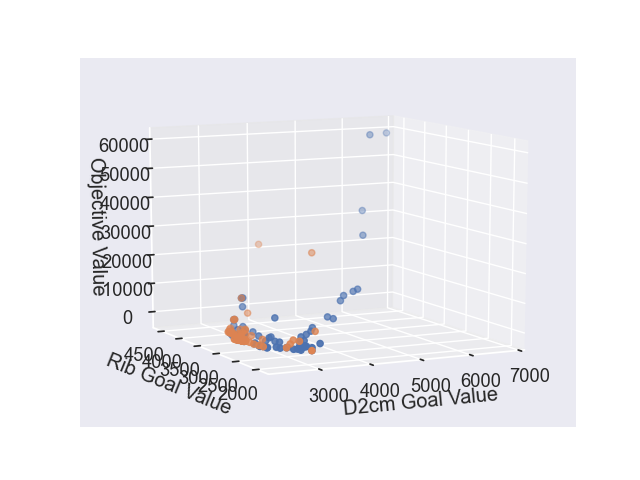

Text(0.5, 0, 'Objective Value')

In [21]:
# Parameters vs. Objective
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(res_dummy.goal_dict[3], res_dummy.goal_dict[18], 
             res_dummy.opt_result.func_vals)
ax.scatter3D(res_bayes.goal_dict[3], res_bayes.goal_dict[18], 
             res_bayes.opt_result.func_vals)
ax.set_xlabel('D2cm Goal Value')
ax.set_ylabel('Rib Goal Value')
ax.set_zlabel('Objective Value')

Similar observations to utility vs. parameters.

<IPython.core.display.Javascript object>


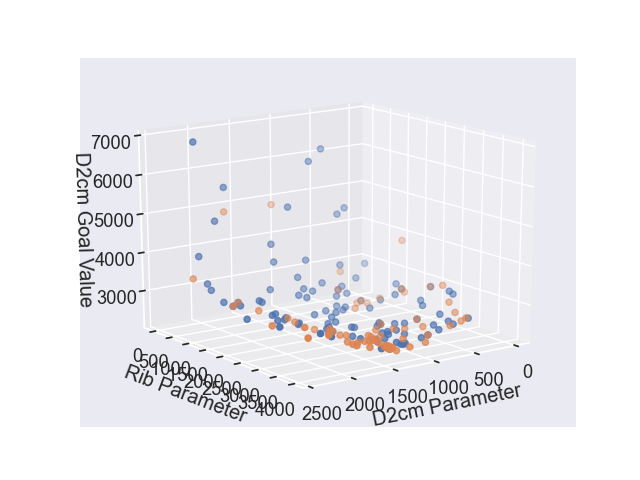

Text(0.5, 0, 'D2cm Goal Value')

In [12]:
# Parameters vs. D2cm Goal
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
             [row[1] for row in res_dummy.opt_result.x_iters], 
             res_dummy.goal_dict[3])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[3])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('D2cm Goal Value')

Here we have a more interesting shape of the Rib MaxDose value vs. the two parameters. Sort of saddle like? 

<IPython.core.display.Javascript object>


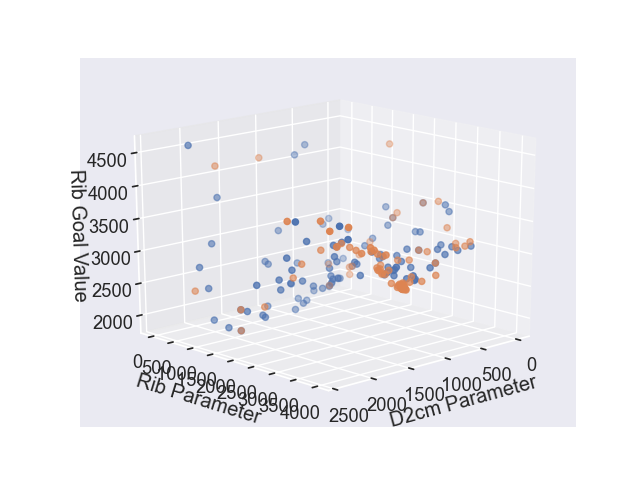

Text(0.5, 0, 'Rib Goal Value')

In [13]:
# Parameters vs. Rib Goal
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D([row[0] for row in res_dummy.opt_result.x_iters], 
             [row[1] for row in res_dummy.opt_result.x_iters], 
             res_dummy.goal_dict[18])
ax.scatter3D([row[0] for row in res_bayes.opt_result.x_iters], 
             [row[1] for row in res_bayes.opt_result.x_iters], 
             res_bayes.goal_dict[18])
ax.set_xlabel('D2cm Parameter')
ax.set_ylabel('Rib Parameter')
ax.set_zlabel('Rib Goal Value')